### Define Helper Functions

In [13]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from datetime import datetime,date,timedelta
import json 
from collections import deque
import pickle
import functools
import time

import multiprocessing  

import re

def matchLineIndex(s):
    ### Convert GLD notation to GeoJson Notation
    integer_list=re.findall(r'\d+', s)    
    return 'line'+integer_list[0]+"to"+integer_list[1]

def disaggMap(dataFrame,nodes_to_loads,parseCase,meters):
    dataFrames=[]
    total=0
    for elem in meters:
        #print(len(dataFrame))
        frame=dataFrame[dataFrame['month']==parseCase['month']].copy(deep=True)
        frame['node']=elem
        counts=nodes_to_loads[nodes_to_loads['name']==elem]
        #print(counts)

        for index,row in frame.iterrows():
            for typ in counts.keys():
                if row['type']==typ:
                    #print(list(frame.columns.difference(['node','hour_of_day','month','type'])))
                    for id in list(frame.columns.difference(['node','hour_of_day','month','type'])):
                        frame.loc[index, id]=float(row[id])*float(counts[typ])
        dataFrames.append(frame)
    finalFrame=pd.concat(dataFrames)
    return(finalFrame)


def getPickles(mypath):
    pickleFiles={}
    for f in set(listdir(mypath)):
        if isfile(join(mypath, f)) and (f[-6:]=="pickle"):
            path=join(mypath, f)
            resourceType=f.replace('.pickle','')
            pickleFiles[resourceType]=path
    return pickleFiles

def parseLoadNodeNames(name):
    if name[0:4]=='load':
        number=name.split('load:')
        nodeType='load_'
    if name[0:4]=='node':
        number=name.split('node:')
        nodeType='node_'
    return nodeType+str(number[1])    
from collections import defaultdict

def children(token, tree):
    "returns a list of every child"
    visited = set()
    to_crawl = deque([token])
    while to_crawl:
        current = to_crawl.popleft()
        if current in visited:
            continue
        visited.add(current)
        node_children = set(tree[current])
        to_crawl.extend(node_children - visited)
    return list(visited)

def addDashtoNodeName(nodename):
    nodename=nodename.split('node')
    return('node_'+nodename[1])

def addDashtoLoadName(loadname):
    loadname=loadname.split('load')
    return('load_'+loadname[1])

def columnFormat(columnName):
    columnName=columnName.lower()
    if columnName[0:4]=='node':
        columnName=addDashtoNodeName(columnName)
    if columnName[0:4]=='load':
        columnName=addDashtoLoadName(columnName)
    return columnName

def monthMapper(month):
    date = datetime(2000, month, 1)  # We need a dateobject with the proper month
    return date.strftime('%B').lower()

def parseVoltages(voltage_files):
    voltage_dfs={}
    voltage_dfs_flattened={}
    for voltage_name,filename in voltage_files.items():
        voltage_dfs[voltage_name]=pd.read_csv(filename,skiprows=list(range(0,8)),parse_dates=['# timestamp'])

    for voltage_name,df in voltage_dfs.items():
        df.columns = [columnFormat(col_name) for col_name in df.columns]
        df['# timestamp'] = df['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        df['month'] = df['# timestamp'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['# timestamp'].map(lambda x: x.hour)
        df['day_of_month'] = df['# timestamp'].map(lambda x: x.day)
        df['timezone']= df['# timestamp'].map(lambda x: x.tz)
        ### Get all the node names
        nodeNames=[]
        for columnName in df.columns:
            if columnName[0:4]=='node':
                nodeNames.append(columnName)
            if columnName[0:4]=='load':
                nodeNames.append(columnName)

        df=pd.melt(df, id_vars=['month','hour_of_day','day_of_month'],var_name='node',value_vars=nodeNames, value_name=voltage_name+'_magnitude')
        df[voltage_name+'_magnitude']=df[voltage_name+'_magnitude'].map(lambda x:abs(complex(x.replace('i','j'))))


        voltage_dfs_flattened[voltage_name]=df
    voltageData = functools.reduce(lambda left,right: pd.merge(left,right,on=['month', 'day_of_month', 'hour_of_day','node']), voltage_dfs_flattened.values())
    
#     for vname,vframe in voltage_dfs_flattened.items():
#         voltageData=voltageData.merge(vframe,on=['month', 'day_of_month', 'hour_of_day','node'],how='left')

    return(voltageData)

def tryconvertreal(value):
        try:
            S=complex(value.replace('i','j'))
            return S.real
        except:
            return value

        
def tryconvertimag(value):
        try:
            S=complex(value.replace('i','j'))
            return S.imag
        except:
            return value
        
def tryconvertmag(value):
        try:
            return abs(complex(value.replace('i','j')))
        except:
            return value
        
def parsePowerFlow(power_files):
    power_dfs={}
    power_dfs_flattened={}
    for power_name,filename in power_files.items():
        power_dfs[power_name]=pd.read_csv(filename,skiprows=list(range(0,8)),parse_dates=['# timestamp'])

    for power_name,df in power_dfs.items():
        df['# timestamp'] = df['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific'))
        df['month'] = df['# timestamp'].map(lambda x: monthMapper(x.month))
        df['hour_of_day'] = df['# timestamp'].map(lambda x: x.hour)
        df['day_of_month'] = df['# timestamp'].map(lambda x: x.day)
        df['timezone']= df['# timestamp'].map(lambda x: x.tz)
        
        lineNames=[]
        replaceCols=[]
        for lineName in df.columns:
            if lineName[0]=='O':
                geoJsonLineName=matchLineIndex(lineName)
                lineNames.append(geoJsonLineName)
                replaceCols.append(geoJsonLineName)
            else:
                replaceCols.append(lineName)

        df.columns=replaceCols
        df=pd.melt(df, id_vars=['month','hour_of_day','day_of_month'],var_name='line',value_vars=lineNames, value_name=power_name+'_magnitude')
        df[power_name+'_P']=df[power_name+'_magnitude'].map(lambda x:tryconvertreal(x))
        df[power_name+'_Q']=df[power_name+'_magnitude'].map(lambda x:tryconvertimag(x))
        df[power_name+'_magnitude']=df[power_name+'_magnitude'].map(lambda x:tryconvertmag(x))


        power_dfs_flattened[power_name]=df
    powerData = functools.reduce(lambda left,right: pd.merge(left,right,on=['month', 'day_of_month', 'hour_of_day','line']), power_dfs_flattened.values())

    return(df,powerData)


### Prepare Lists to Iterate Over Then Parse DERCAM, GridlabD and Topology Files for Distribution System View

In [43]:
dataKeys=['hourly_pv_self_consumpt',
          'hourly_pv_export',
          'elec_stored_stationnary_batteries',
          'purchase_from_utility',
          'elec_provided_by_stationnary_battery_charging_after_eff','pv_inst','storage_inst','chp_inst']
##pv_inst
##storage_inst
##chp_inst
for scenario_number in [1,2,3,4]:
    scenario_names=['BC','PV','PV+STO','PV+STO+CHP']
    scenario_name=scenario_names[scenario_number-1]
    save_final_data_file='../GMLCDjangoProject/MapApp/static/MapApp/data/scenario'+str(scenario_number-1)+'.csv'

    parseList=[]
    for i in range(1,13):
        mydate = date(2016,i,1)

        fileLocation="/Month"+"%02d" % i +"/output/"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+fileLocation
        gld=pd.read_csv(gridlabd_scenario_path+'/nodes_voltage_A.csv',skiprows=list(range(0,8)),parse_dates=['# timestamp'])
        datetimes=gld['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific').date())
        dayWeekday={}
        weekend=False
        weekday=False
        for elem in sorted(set(datetimes)):
            if elem.weekday()<5:
                weekday=elem.day
            else: 
                weekend=elem.day

            if weekend & weekday:
                break
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekday':weekday})
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekend':weekend})



    merge_list=[]


    for parseCase in parseList:

        dercam_scenario_path="./DERCAM_Results/"+scenario_name+"/gmlc/buildings"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']
                         
                         
        filenames=getPickles(dercam_scenario_path)




        voltage_files={'voltage_a':gridlabd_scenario_path+'/nodes_voltage_A.csv',
                       'voltage_b':gridlabd_scenario_path+'/nodes_voltage_B.csv',
                       'voltage_c':gridlabd_scenario_path+'/nodes_voltage_C.csv',}

        load_voltages={'voltage_a':gridlabd_scenario_path+'/loads_voltage_A.csv',
                       'voltage_b':gridlabd_scenario_path+'/loads_voltage_B.csv',
                       'voltage_c':gridlabd_scenario_path+'/loads_voltage_C.csv'}


        #### PARSE GRIDLABD
        print("*********Parsing GridlabD")

        st_time=time.time()
        print(voltage_files)
        print(load_voltages)
        voltageData=parseVoltages(voltage_files)
        loadVoltageData=parseVoltages(load_voltages)
        if 'weekend' in parseCase.keys():
            print('Parsing Weekend')
            day_of_month=parseCase['weekend']
            weekend=True
        else:
            day_of_month=parseCase['weekday']
            weekend=False

        daily_node_voltage=voltageData[voltageData['month']==parseCase['month']][voltageData['day_of_month']==day_of_month][["month","hour_of_day","node",
                                                                                                         "voltage_b_magnitude","voltage_c_magnitude" ,"voltage_a_magnitude"]]
        daily_load_voltage=loadVoltageData[loadVoltageData['month']==parseCase['month']][loadVoltageData['day_of_month']==day_of_month][["month","hour_of_day","node",
                                                                                                          "voltage_b_magnitude","voltage_c_magnitude" ,"voltage_a_magnitude"]]
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2

        print("*********Parsing DERCAM")

        ### PARSE DERCAM FILES
        ## Flatten files to facilitate the use of crossfilter and dc.js
        if weekend:
            keys=['weekend']
        else:
            keys=['week']
        dataFrames=[]
        for resourceType,filename in filenames.items():
            #print("reading "+filename)
            try:
                with open(filename, 'rb') as input_file:
                    data = pickle.load(input_file)
                ct=0
                print('These exist')
                print([val for val in set(list(data.keys())) if val in set(dataKeys)])
                print('These are missing')
                print(set(list(data.keys())).symmetric_difference(set(dataKeys)))
                for elem in dataKeys:
                    try:
                        for key in keys:#data[elem].keys():
                            #print(filename,elem,key)
                            #print(data[elem].keys())
                            dummy=data[elem][key]
                            #ataFrame['type']=key
                            #ataFrame['variable']=elem
                            dummy=pd.melt(dummy, id_vars=['month'],var_name='hour_of_day',value_name=elem)
                            dummy[elem] = dummy[elem].astype(float)
                            if ct==0:
                                dataFrame=dummy
                            if ct>0:
                                dataFrame=pd.merge(dataFrame,dummy,on=['month','hour_of_day'])
                            ct=ct+1
                    except:
                        print('failed for '+filename,elem)
                        continue
                dataFrame['type']=resourceType
                dataFrames.append(dataFrame)
            except:
                print("Couldn't process "+filename)

        dataFrame=pd.concat(dataFrames)
        dataFrame=dataFrame.fillna(value=0)
        dataFrame=dataFrame.reset_index(drop=True)
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2



        ### PARSE TOPOLOGY
        print("*********Parsing Topology")
        with open('ieee123.json') as data_file:    
            data = json.load(data_file)
        fromToDict=defaultdict(list)
        for elem in data:
            if 'overhead_line:' in elem['selector']:
                fromToDict[parseLoadNodeNames(elem["properties"]['from'])].append(parseLoadNodeNames(elem["properties"]['to']))


        nodeChildrenDict=defaultdict(list)
        for node in set(daily_node_voltage['node']):
            for elem in children(node,fromToDict):
                if elem[0:4]=='load':
                    nodeChildrenDict[node].append(elem)

        nodes_to_loads=pd.read_csv(dercam_scenario_path+"/disaggregation.csv")
        nodes_to_loads['name']=nodes_to_loads['name'].apply(lambda x:x.replace('Load','load_') )


        for node,node_list in nodeChildrenDict.items():
            dummy=nodes_to_loads[
                nodes_to_loads['name'].isin(
                    node_list)].sum(axis=0)
            dummy['name']=node
            nodes_to_loads=nodes_to_loads.append(dummy, ignore_index=True)
        ## Sum up everything and create node and load consumption patterns
        meters=list(nodes_to_loads['name'])
        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2


        ### PARSE DISAGG

        print("*********Parsing Disagg")


        #dataFrame.to_csv('Dercam_initial.csv')
        #nodes_to_loads.to_csv('nodes_to_loads.csv')


        finalFrame=disaggMap(dataFrame,nodes_to_loads,parseCase,meters)

        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2
        ## Down select DERCAM data to match the first month

        dercamData=finalFrame[finalFrame['month']==parseCase['month']]
        dercamData['hour_of_day']=dercamData['hour_of_day'].apply(lambda x:x-1)
        ## Stich everything GLD and DERCAM all together
        voltageFrame=daily_load_voltage.append(daily_node_voltage)
        merge_test=dercamData.merge(voltageFrame,on=['month', 'hour_of_day','node'],how='left')
        if weekend:
            merge_test['daytype']='weekend'
        else:
            merge_test['daytype']='weekday'
        #merge_test=merge_test.merge(daily_node_voltage,on=['month', 'hour_of_day','node'],how='left')
        merge_list.append(merge_test)




    print('Saving file to '+save_final_data_file)
    merge_test_df=pd.concat(merge_list)
    merge_test_df.reset_index(drop=True).to_csv(save_final_data_file)








*********Parsing GridlabD
{'voltage_a': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_A.csv', 'voltage_b': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_B.csv', 'voltage_c': './GRIDLABD_Results/BC/Month01/output//nodes_voltage_C.csv'}
{'voltage_a': './GRIDLABD_Results/BC/Month01/output//loads_voltage_A.csv', 'voltage_b': './GRIDLABD_Results/BC/Month01/output//loads_voltage_B.csv', 'voltage_c': './GRIDLABD_Results/BC/Month01/output//loads_voltage_C.csv'}
Took  0.2205970287322998
*********Parsing DERCAM
These exist
['hourly_pv_self_consumpt', 'purchase_from_utility', 'elec_provided_by_stationnary_battery_charging_after_eff', 'pv_inst', 'elec_stored_stationnary_batteries', 'storage_inst', 'hourly_pv_export']
These are missing
{'chp_inst', 'ren_gen', 'renewables_new_capacity', 'net_load', 'energy_storage_new_capacity', 'elec_for_stationnary_battery_charging_before_eff', 'doc', 'OPEX_saving'}
failed for ./DERCAM_Results/BC/gmlc/buildings/Warehouse.pickle.pickle hourly_pv_self_

### Match Line Notation Between GeoJson and Line Power Data

In [11]:
gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']

### Get headers of each data file overhead, underground 
file_names=["underground_lines_power_in_A", 
            "Overhead_lines_power_in_A",
            "underground_lines_power_in_B", 
            "Overhead_lines_power_in_B",
            "underground_lines_power_in_C", 
            "Overhead_lines_power_in_C",
           ]

line_df={}
lines=[]
for filename in file_names:
    line_df[filename]=pd.read_csv(gridlabd_scenario_path+filename+".csv",skiprows=list(range(0,8)),parse_dates=['# timestamp'])
    lines=lines+list(line_df[filename].keys())

### Final list of lines 
lines=list(set(lines))
lines.remove('# timestamp')

### Get lines from the geojson
geoJsonData = json.load(open('../GMLCDjangoProject/MapApp/static/MapApp/data/model2.geo.json'))

lines_in_geojson=[]
for feature in geoJsonData['features']:
    if feature["geometry"]["type"]=="LineString":
        lines_in_geojson.append(feature['properties']['name'])

lines_in_geojson=list(set(lines_in_geojson))

matched_lines=[]
for elem in lines:
    matched_lines.append(matchLineIndex(elem))    
mismatch_list=[]
for elem in matched_lines:
    if elem not in lines_in_geojson:
        mismatch_list.append(elem)


In [44]:
dataKeys=['hourly_pv_self_consumpt',
          'hourly_pv_export',
          'elec_stored_stationnary_batteries',
          'purchase_from_utility',
          'elec_provided_by_stationnary_battery_charging_after_eff']
##pv_inst
##storage_inst
##chp_inst
for scenario_number in [1,2,3,4]:
    scenario_names=['BC','PV','PV+STO','PV+STO+CHP']
    scenario_name=scenario_names[scenario_number-1]
    save_final_data_file='../GMLCDjangoProject/MapApp/static/MapApp/data/scenario'+str(scenario_number-1)+'_lines.csv'

    parseList=[]
    for i in range(1,13):
        mydate = date(2016,i,1)

        fileLocation="/Month"+"%02d" % i +"/output/"
        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+fileLocation
        gld=pd.read_csv(gridlabd_scenario_path+'/nodes_voltage_A.csv',skiprows=list(range(0,8)),parse_dates=['# timestamp'])
        datetimes=gld['# timestamp'].map(lambda x: x.tz_localize('UTC').tz_convert('US/Pacific').date())
        dayWeekday={}
        weekend=False
        weekday=False
        for elem in sorted(set(datetimes)):
            if elem.weekday()<5:
                weekday=elem.day
            else: 
                weekend=elem.day

            if weekend & weekday:
                break
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekday':weekday})
        parseList.append({'month':mydate.strftime("%B").lower(),'filename':"/Month"+"%02d" % i +"/output/",'weekend':weekend})



    merge_list=[]
    for parseCase in parseList:

        gridlabd_scenario_path='./GRIDLABD_Results/'+scenario_name+parseCase['filename']

        overhead_power_flow_files={'power_in_a':gridlabd_scenario_path+'Overhead_lines_power_in_A.csv',
                                   'power_in_b':gridlabd_scenario_path+'Overhead_lines_power_in_B.csv',
                                   'power_in_c':gridlabd_scenario_path+'Overhead_lines_power_in_C.csv'
                            }
        overhead_power_flow_out_files={'power_out_a':gridlabd_scenario_path+'Overhead_lines_power_out_A.csv',
                                   'power_out_b':gridlabd_scenario_path+'Overhead_lines_power_out_B.csv',
                                   'power_out_c':gridlabd_scenario_path+'Overhead_lines_power_out_C.csv'
                            }

    #     underground_power_flow_files={'power_in_a':gridlabd_scenario_path+'underground_lines_power_in_A.csv',
    #                                   'power_in_b':gridlabd_scenario_path+'underground_lines_power_in_B.csv',
    #                                   'power_in_c':gridlabd_scenario_path+'underground_lines_power_in_C.csv'
    #                     }

    #     underground_power_flow_out_files={'power_out_a':gridlabd_scenario_path+'underground_lines_power_in_A.csv',
    #                               'power_out_b':gridlabd_scenario_path+'underground_lines_power_in_B.csv',
    #                               'power_out_c':gridlabd_scenario_path+'underground_lines_power_in_C.csv'
    #                 }
        #### PARSE GRIDLABD
        print("*********Parsing GridlabD")

        st_time=time.time()
        df,powerOverHeadData=parsePowerFlow(overhead_power_flow_files)
    #     df,powerUnderGroundData=parsePowerFlow(underground_power_flow_files)

        df,powerOverHeadOutData=parsePowerFlow(overhead_power_flow_out_files)
    #     df,powerUnderGroundOutData=parsePowerFlow(underground_power_flow_out_files)

        if 'weekend' in parseCase.keys():
            print('Parsing Weekend')
            day_of_month=parseCase['weekend']
            weekend=True
        else:
            day_of_month=parseCase['weekday']
            weekend=False

        daily_overhead_line_power=powerOverHeadData[powerOverHeadData['month']==parseCase['month']][powerOverHeadData['day_of_month']==day_of_month][["month","hour_of_day","line",
                                                                                                         "power_in_b_magnitude","power_in_c_magnitude" ,"power_in_a_magnitude",
                                                                                                         "power_in_b_Q","power_in_c_Q" ,"power_in_a_Q",
                                                                                                           "power_in_b_P","power_in_c_P" ,"power_in_a_P"]]

    #     daily_underground_line_power=powerUnderGroundData[powerUnderGroundData['month']==parseCase['month']][powerUnderGroundData['day_of_month']==day_of_month][["month","hour_of_day","line",
    #                                                                                                      "power_in_b_magnitude","power_in_c_magnitude" ,"power_in_a_magnitude"]]

        daily_overhead_line_out_power=powerOverHeadOutData[powerOverHeadOutData['month']==parseCase['month']][powerOverHeadOutData['day_of_month']==day_of_month][["month","hour_of_day","line",
                                                                                                         "power_out_b_magnitude","power_out_c_magnitude" ,"power_out_a_magnitude",
                                                                                                         "power_out_b_Q","power_out_c_Q" ,"power_out_a_Q",
                                                                                                           "power_out_b_P","power_out_c_P" ,"power_out_a_P"]]

        st_time2=time.time()
        print("Took ",st_time2-st_time)
        st_time=st_time2

    #    powerFrame=daily_overhead_line_power.append(daily_underground_line_power)
    #    powerOutFrame=daily_overhead_line_out_power.append(daily_underground_line_out_power)


        powerFrame=daily_overhead_line_power
        powerOutFrame=daily_overhead_line_out_power
        merge_test=powerFrame.merge(powerOutFrame,on=['month', 'hour_of_day','line'],how='left')


        if weekend:
            merge_test['daytype']='weekend'
        else:
            merge_test['daytype']='weekday'

        merge_test['power_flow_a']=merge_test['power_in_a_magnitude']-merge_test['power_out_a_magnitude']
        merge_test['power_flow_b']=merge_test['power_in_b_magnitude']-merge_test['power_out_b_magnitude']
        merge_test['power_flow_c']=merge_test['power_in_c_magnitude']-merge_test['power_out_c_magnitude']
        
        merge_test['power_flow_a_Q']=merge_test['power_in_a_Q']-merge_test['power_out_a_Q']
        merge_test['power_flow_b_Q']=merge_test['power_in_b_Q']-merge_test['power_out_b_Q']
        merge_test['power_flow_c_Q']=merge_test['power_in_c_Q']-merge_test['power_out_c_Q']


        merge_test['power_flow_a_P']=merge_test['power_in_a_P']-merge_test['power_out_a_P']
        merge_test['power_flow_b_P']=merge_test['power_in_b_P']-merge_test['power_out_b_P']
        merge_test['power_flow_c_P']=merge_test['power_in_c_P']-merge_test['power_out_c_P']





        #merge_test=merge_test.merge(daily_node_voltage,on=['month', 'hour_of_day','node'],how='left')
        merge_list.append(merge_test)




    print('Saving file to '+save_final_data_file)
    merge_test_df=pd.concat(merge_list)
    merge_test_df.reset_index(drop=True).to_csv(save_final_data_file)






*********Parsing GridlabD
Took  0.6903760433197021
*********Parsing GridlabD
Parsing Weekend
Took  0.6529929637908936
*********Parsing GridlabD
Took  0.4850454330444336
*********Parsing GridlabD
Parsing Weekend
Took  0.49858617782592773
*********Parsing GridlabD
Took  0.36746788024902344
*********Parsing GridlabD
Parsing Weekend
Took  0.3653531074523926
*********Parsing GridlabD
Took  0.3401951789855957
*********Parsing GridlabD
Parsing Weekend
Took  0.3437838554382324
*********Parsing GridlabD
Took  0.42154979705810547
*********Parsing GridlabD
Parsing Weekend
Took  0.37958502769470215
*********Parsing GridlabD
Took  0.370725154876709
*********Parsing GridlabD
Parsing Weekend
Took  0.3967108726501465
*********Parsing GridlabD
Took  0.4030008316040039
*********Parsing GridlabD
Parsing Weekend
Took  0.4917910099029541
*********Parsing GridlabD
Took  0.40772390365600586
*********Parsing GridlabD
Parsing Weekend
Took  0.5036399364471436
*********Parsing GridlabD
Took  0.45844411849975586


### JUNK BELOW

/Users/emrecan/Work_Git/GMLC/venv/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


KeyError: 'week_purchase_from_utility'

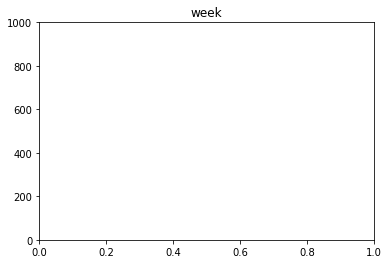

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt



%matplotlib inline
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
for elem in ['week','weekend','peak']:
    plt.figure()
    plt.title(elem)
    plt.ylim([0,1000])
    ax = sns.tsplot(time="hour_of_day", value=elem+"_purchase_from_utility", unit="month",condition="type",data=dataFrame)
    # ax = sns.tsplot(time="hour_of_day", value="peak_purchase_from_utility",
    #                  unit="subject", condition="type",
    #                  data=dataFrame)
    ax.lines[0].set_marker('o')
    ax.lines[1].set_marker('<')
    ax.legend()
    plt.figure()
    plt.ylim([0,1000])
    ax = sns.tsplot(time="hour_of_day", value=elem+"_hourly_pv_self_consumpt", unit="month",condition="type",data=dataFrame)
    ax.lines[0].set_marker('o')
    ax.lines[1].set_marker('<')
    ax.legend()


In [ ]:
dataFrame['peak_hourly_pv_export'][0]